# ✅ Project: Bank IT Support Ticket Classification
## 📌 Project Title:
### Intent Classification of Bank IT Support Tickets using Traditional ML + Embeddings

### 📖 Description: 
This project focuses on classifying the intent behind customer IT support queries in the banking domain. The dataset includes domain, subdomain, category, user query (example), and intent labels. The goal is to build a multi-class classification system that can automate ticket intent detection using sentence embeddings and machine learning classifiers.

## 🧱 Notebook Structure & Sections

### ✅ 1. Importing Required Libraries
- Start by importing essential libraries (pandas, numpy, seaborn, sklearn, xgboost, lightgbm, matplotlib, etc.).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier

### 📊 2. Data Loading & Exploration:

- Dataset was loaded using HuggingFace dataset hub.
- Inspected and visualized for understanding data balance.

In [2]:
#Data Loading and Inspecting the Data
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/rbojja/labelled_bank_support_dataset/" + splits["train"])

In [3]:
df.head()

,domain,subdomain,category,example,intent
0,Loan Products and Interest Rates,Interest rates calculation and breakdown,Comparing Fixed vs. Variable Interest Rates,Can you explain the differences between fixed ...,1
1,Customer Interaction Experience,incorrect_account_charges,Clarification of Charges,Can you clarify why I was charged a fee for my...,1
2,Deposit Confirmation,Deposit Cancellation Confirmation,Customer Support for Cancellation Inquiries,Could you please verify that my deposit cancel...,2
3,Service Offerings,Introduction to customer service features,Overview of Customer Service Features,How can I access your customer service feature...,1
4,Deposit Accounts and Interest Calculation,Impact of Interest Rates on Savings,How Central Bank Rates Influence Personal Savi...,How do changes in the central bank's interest ...,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   domain     5500 non-null   object
 1   subdomain  5500 non-null   object
 2   category   5500 non-null   object
 3   example    5500 non-null   object
 4   intent     5500 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 215.0+ KB


In [5]:
df.describe()

,intent
count,5500.000000
mean,2.254545
std,2.843740
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,10.000000


In [6]:
df['full_text'] = (
    df['domain'].astype(str) + ' ' +
    df['subdomain'].astype(str) + ' ' +
    df['category'].astype(str) + ' ' +
    df['example'].astype(str)
)

In [7]:
df.drop(['domain', 'subdomain', 'category', 'example'], axis = 1, inplace = True)

In [8]:
df.head()

,intent,full_text
0,1,Loan Products and Interest Rates Interest rate...
1,1,Customer Interaction Experience incorrect_acco...
2,2,Deposit Confirmation Deposit Cancellation Conf...
3,1,Service Offerings Introduction to customer ser...
4,3,Deposit Accounts and Interest Calculation Impa...


In [9]:
#Seprating Numerical and Categorical Columns
full_text = ['full_text']
target = 'intent'

In [10]:
#Meaning of Classes Labels Here
'''
0 - Apology
1 - Clarification
2 - Confirmation
3 - Explaining
4 - Farewell
5 - Greeting
6 - Negative
7 - Neutral
8 - Positive
9 - Thanking
10 - Unsure
'''

'\n0 - Apology\n1 - Clarification\n2 - Confirmation\n3 - Explaining\n4 - Farewell\n5 - Greeting\n6 - Negative\n7 - Neutral\n8 - Positive\n9 - Thanking\n10 - Unsure\n'

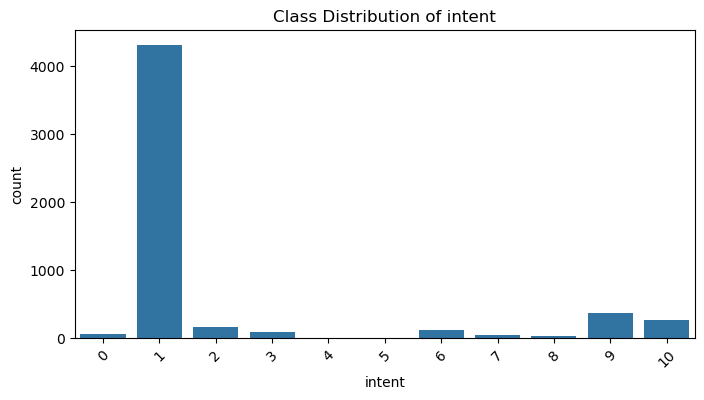

In [11]:
#Checking Class Imabalance in Target Variable
plt.figure(figsize=(8, 4))
sns.countplot(x=target, data=df)
plt.title(f'Class Distribution of {target}')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Check percentage distribution of target classes
class_counts = df[target].value_counts(normalize=True) * 100
print(class_counts)

intent
1     78.418182
9      6.763636
10     4.981818
2      3.018182
6      2.236364
3      1.781818
0      1.181818
7      0.836364
8      0.600000
5      0.163636
4      0.018182
Name: proportion, dtype: float64


### ✅ 3. Train-Test Split

In [13]:
X = df.drop(target, axis = 1)
y = df[target]

In [14]:
# Splitting the Data for LLM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### ✅ 4. Feature Engineering
- Text Vectorization: Used SentenceTransformer to extract embeddings from the example column (user query) for full_text (For LLM)
- Used TF-IDF to transform full_text (For TF-IDF)

In [15]:
# Load a lightweight, high-performing model
embedder = SentenceTransformer('all-MiniLM-L6-v2')
X_train_llm = embedder.encode(X_train[full_text[0]].astype(str).tolist(), show_progress_bar=True)
X_test_llm = embedder.encode(X_test[full_text[0]].astype(str).tolist(), show_progress_bar=True)

Batches:   0%|          | 0/129 [00:00<?, ?it/s]

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

In [16]:
X_train_llm.shape, X_test_llm.shape

((4125, 384), (1375, 384))

In [17]:
#Initialize and fit TF-IDF
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train[full_text[0]].astype(str)).toarray()
X_test_tfidf = tfidf.transform(X_test[full_text[0]].astype(str)).toarray()

In [18]:
X_train_tfidf.shape, X_test_tfidf.shape

((4125, 1000), (1375, 1000))

### ✅ 5 Model Training & Evaluation:
- Trained Logistic Regression, Random Forest, KNN, SVM, SGD, Multi-layer Perceptron classifiers
- Evaluated using Accuracy, Precision, Recall, and F1-score.

In [19]:
models = {
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=4),
    'SVM': SVC(probability=True, random_state=42)
}

### ✅ 5.2 - LLM Embeddings with SentenceTransformer (BERT)
- Used sentence-transformers to convert full_text into dense vectors
- Replaced TF-IDF vector with LLM embeddings

In [20]:
for name, model in models.items():
    model.fit(X_train_llm, y_train)
    y_pred_llm = model.predict(X_test_llm)
    
    print(f"\n🔍 {name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred_llm))
    print("Classification Report:\n", classification_report(y_test, y_pred_llm))

    # --- Get Nearest Neighbors for First Test Sample ---
    if name == 'KNN':
        distances, indices = model.kneighbors(X_test_llm[:1])  # first test instance
        print(f"\n📌 Nearest Neighbors for First Test Sample:")
        print("Indices:", indices[0])
        print("Distances:", distances[0])
        print("Neighbor Labels:", y_train.iloc[indices[0]])


🔍 Random Forest Evaluation:
Accuracy: 0.8305454545454546
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.33      0.47        12
           1       0.83      1.00      0.90      1068
           2       0.78      0.15      0.25        48
           3       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         3
           6       1.00      0.03      0.05        40
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00         7
           9       0.93      0.70      0.80        92
          10       0.00      0.00      0.00        62

    accuracy                           0.83      1375
   macro avg       0.43      0.22      0.25      1375
weighted avg       0.77      0.83      0.77      1375


🔍 Logistic Regression Evaluation:
Accuracy: 0.8501818181818181
Classification Report:
               precision    recall  f1-score   support

           0    

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco


🔍 KNN Evaluation:
Accuracy: 0.832
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.83      0.54        12
           1       0.87      0.95      0.91      1068
           2       0.52      0.33      0.41        48
           3       0.29      0.09      0.13        23
           5       0.00      0.00      0.00         3
           6       0.40      0.15      0.22        40
           7       1.00      0.10      0.18        20
           8       0.00      0.00      0.00         7
           9       0.87      0.89      0.88        92
          10       0.35      0.13      0.19        62

    accuracy                           0.83      1375
   macro avg       0.47      0.35      0.35      1375
weighted avg       0.80      0.83      0.80      1375


📌 Nearest Neighbors for First Test Sample:
Indices: [3365 4076  765 3890]
Distances: [0.42282924 0.42479843 0.49115926 0.53148186]
Neighbor Labels: 302     0
2061    0
4162    0
364

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔍 SVM Evaluation:
Accuracy: 0.8472727272727273
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.58      0.56        12
           1       0.85      0.99      0.91      1068
           2       0.74      0.29      0.42        48
           3       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         3
           6       1.00      0.03      0.05        40
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00         7
           9       0.89      0.93      0.91        92
          10       0.00      0.00      0.00        62

    accuracy                           0.85      1375
   macro avg       0.40      0.28      0.29      1375
weighted avg       0.78      0.85      0.79      1375



/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### ✅ 5.1 - Modeling: TF-IDF Based Pipeline
- Encoded text features into one combined matrix

In [21]:
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred_tfidf = model.predict(X_test_tfidf)
    
    print(f"\n🔍 {name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
    print("Classification Report:\n", classification_report(y_test, y_pred_tfidf))

    # --- Get Nearest Neighbors for First Test Sample ---
    if name == 'KNN':
        distances, indices = model.kneighbors(X_test_tfidf[:1])  # first test instance
        print(f"\n📌 Nearest Neighbors for First Test Sample:")
        print("Indices:", indices[0])
        print("Distances:", distances[0])
        print("Neighbor Labels:", y_train.iloc[indices[0]])


🔍 Random Forest Evaluation:
Accuracy: 0.8632727272727273
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.87      0.99      0.92      1068
           2       0.88      0.58      0.70        48
           3       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         3
           6       0.50      0.05      0.09        40
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00         7
           9       0.87      0.96      0.91        92
          10       0.45      0.08      0.14        62

    accuracy                           0.86      1375
   macro avg       0.45      0.36      0.37      1375
weighted avg       0.81      0.86      0.82      1375



/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🔍 Logistic Regression Evaluation:
Accuracy: 0.8552727272727273
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.85      0.99      0.92      1068
           2       0.89      0.35      0.51        48
           3       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         3
           6       1.00      0.05      0.10        40
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00         7
           9       0.87      0.93      0.90        92
          10       0.64      0.11      0.19        62

    accuracy                           0.86      1375
   macro avg       0.53      0.30      0.33      1375
weighted avg       0.82      0.86      0.81      1375


🔍 KNN Evaluation:
Accuracy: 0.8414545454545455


/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.92      0.63        12
           1       0.87      0.96      0.91      1068
           2       0.45      0.27      0.34        48
           3       0.40      0.09      0.14        23
           5       0.00      0.00      0.00         3
           6       0.53      0.20      0.29        40
           7       1.00      0.15      0.26        20
           8       0.00      0.00      0.00         7
           9       0.90      0.92      0.91        92
          10       0.39      0.11      0.17        62

    accuracy                           0.84      1375
   macro avg       0.50      0.36      0.37      1375
weighted avg       0.81      0.84      0.81      1375


📌 Nearest Neighbors for First Test Sample:
Indices: [3890 3365  765 3210]
Distances: [0.81331593 0.8741024  0.93895769 0.96600866]
Neighbor Labels: 3643    0
302     0
4162    0
5296    0
Name: intent, dtype: int64



/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### ✅ 7. Hyperparameter Tuning (Validation Step)
- Hyperparameter tuning with GridSearchCV for Logistic Regression, SGD Classifier, MLP Classifier, Random Forest
- Tuned parameters like max_depth, n_estimators, learning_rate etc.
- Applied Gradient Descent 
- Cross-validation
- Re-trained models using the same pipeline
- Compared accuracy & performance with TF-IDF version

In [22]:
#Define Models with Hyperparameter Grids
models = {
    'Logistic Regression': LogisticRegression(solver='saga', max_iter=1000, random_state=42),
    'SGD Classifier': SGDClassifier(random_state=42),
    'MLP Classifier': MLPClassifier(solver='sgd', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42)
}

In [23]:
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1.0],
        'penalty': ['l1', 'l2'],
        'solver': ['saga'],
        'max_iter': [1000]
    },
    'SGD Classifier': {
        'loss': ['log_loss', 'hinge'],  # log_loss = logistic, hinge = SVM
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['optimal', 'adaptive'],
        'eta0': [0.01, 0.1]
    },
    'MLP Classifier': {
        'hidden_layer_sizes': [(50,), (100,)],
        'learning_rate_init': [0.001, 0.01],
        'alpha': [0.0001, 0.001],
        'solver': ['sgd']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

In [24]:
def train_and_evaluate(name, model, param_grid, X_train, y_train, X_test, y_test):
    print(f"\n🔧 Tuning & Training: {name}")
    
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"\n✅ Best Parameters for {name}:\n{grid.best_params_}")
    print(f"\n📊 Evaluation for {name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [26]:
for name in models:
    train_and_evaluate(
        name,
        models[name],
        param_grids[name],
        X_train_llm,
        y_train,
        X_test_llm,
        y_test
    )


🔧 Tuning & Training: Logistic Regression
Fitting 5 folds for each of 6 candidates, totalling 30 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To


✅ Best Parameters for Logistic Regression:
{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}

📊 Evaluation for Logistic Regression:
Accuracy: 0.8501818181818181
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.42      0.53        12
           1       0.85      1.00      0.92      1068
           2       0.77      0.35      0.49        48
           3       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         3
           6       1.00      0.05      0.10        40
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00         7
           9       0.90      0.87      0.88        92
          10       1.00      0.02      0.03        62

    accuracy                           0.85      1375
   macro avg       0.52      0.27      0.29      1375
weighted avg       0.83      0.85      0.80      1375


🔧 Tuning & Training: SGD Classifier
Fitt

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco


✅ Best Parameters for SGD Classifier:
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'elasticnet'}

📊 Evaluation for SGD Classifier:
Accuracy: 0.8392727272727273
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.84      1.00      0.91      1068
           2       0.62      0.10      0.18        48
           3       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00        40
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00         7
           9       0.92      0.84      0.88        92
          10       0.00      0.00      0.00        62

    accuracy                           0.84      1375
   macro avg       0.31      0.24      0.26      1375
weighted avg       0.74      0.84      0.78      1375


🔧 Tuning & T

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco


✅ Best Parameters for MLP Classifier:
{'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'solver': 'sgd'}

📊 Evaluation for MLP Classifier:
Accuracy: 0.8501818181818181
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.67      0.55        12
           1       0.88      0.96      0.92      1068
           2       0.65      0.58      0.62        48
           3       0.33      0.17      0.23        23
           5       1.00      0.33      0.50         3
           6       0.48      0.25      0.33        40
           7       0.00      0.00      0.00        20
           8       0.50      0.14      0.22         7
           9       0.88      0.91      0.89        92
          10       0.57      0.19      0.29        62

    accuracy                           0.85      1375
   macro avg       0.58      0.42      0.45      1375
weighted avg       0.82      0.85      0.83      1375


🔧 Tuning & Training: R

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
for name in models:
    train_and_evaluate(
        name,
        models[name],
        param_grids[name],
        X_train_tfidf,
        y_train,
        X_test_tfidf,
        y_test
    )


🔧 Tuning & Training: Logistic Regression
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



✅ Best Parameters for Logistic Regression:
{'C': 1.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

📊 Evaluation for Logistic Regression:
Accuracy: 0.8618181818181818
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.86      0.98      0.92      1068
           2       0.77      0.48      0.59        48
           3       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         3
           6       0.88      0.17      0.29        40
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00         7
           9       0.89      0.90      0.90        92
          10       0.75      0.24      0.37        62

    accuracy                           0.86      1375
   macro avg       0.51      0.35      0.39      1375
weighted avg       0.83      0.86      0.83      1375


🔧 Tuning & Training: SGD Classifier
Fitt

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco


✅ Best Parameters for SGD Classifier:
{'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l1'}

📊 Evaluation for SGD Classifier:
Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.88      0.98      0.93      1068
           2       0.80      0.73      0.76        48
           3       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         3
           6       0.71      0.12      0.21        40
           7       0.00      0.00      0.00        20
           8       0.00      0.00      0.00         7
           9       0.91      0.96      0.93        92
          10       0.81      0.34      0.48        62

    accuracy                           0.88      1375
   macro avg       0.51      0.41      0.43      1375
weighted avg       0.84      0.88      0.85      1375


🔧 Tuning & Training: MLP Classifie

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaco


✅ Best Parameters for MLP Classifier:
{'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'solver': 'sgd'}

📊 Evaluation for MLP Classifier:
Accuracy: 0.8545454545454545
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.90      0.94      0.92      1068
           2       0.69      0.71      0.70        48
           3       0.28      0.22      0.24        23
           5       0.00      0.00      0.00         3
           6       0.61      0.42      0.50        40
           7       0.50      0.05      0.09        20
           8       0.17      0.14      0.15         7
           9       0.90      0.92      0.91        92
          10       0.33      0.27      0.30        62

    accuracy                           0.85      1375
   macro avg       0.54      0.47      0.48      1375
weighted avg       0.84      0.85      0.84      1375


🔧 Tuning & Training: R

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## ✅ Observations and Conclusion:
- Classifiers struggled due to overlapping intents and possibly limited label diversity.
- While sentence embeddings help extract semantic meaning, the classes (intent) may need hierarchical restructuring or benefit from fine-tuning.
- Moderate accuracy due to semantic similarity between different intents.